# Procurement Process Survey
***
## THIS IS THE PUBLIC VERSION WHERE PROCESSES HAVE BEEN CHANGED TO PROTECT INTERNAL DATA

The following is the analysis of the Procurement survey conducted in February 2018. The survey consisted on 4 questions on 32 processes in Procurement. The goal of the survey was to understand the health of our processes, get valuable feedback from the users to improve the processes, and to understand the overall health of our processes after internal Cloud implementation.

The survey asked questions on the follow processes

* DELETED FOR PUBLIC VERSION

The survey asked the following questions

**How Often Do You Use This Process?:**

Never,
Once per Quarter,
2-3 times per Quarter,
Weekly,
Daily/Multiple Times Per Day 

**This Process is Easy to Use:**

Do Not Use in My Job,
Strongly Disagree,
Disagree,
Agree,
Strongly Agree

**This Process is Effective:**

Do Not Use in My Job,
Strongly Disagree,
Disagree,
Agree,
Strongly Agree

**How could we Improve this Process?:**

Open Text



In [1]:
#Import necessary packages
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime as datetime
from IPython.display import FileLink, FileLinks
%matplotlib inline

In [2]:
survey = pd.read_csv(r"procurement_survey.csv",encoding="cp1252")
survey.head(2)

Response ID      Response Date      Q1              Q2              Q3  \
0    152420861  06-FEB-2018 19:37  Weekly           Agree           Agree   
1    152420863  06-FEB-2018 19:42  Weekly  Strongly Agree  Strongly Agree   

                                                  Q4  \
0  The ability to modify an MT after submission w...   
1                                                NaN   

                             Q5     Q6     Q7  \
0  Daily/multiple times per day  Agree  Agree   
1  Daily/multiple times per day  Agree  Agree   

                                                  Q8  \
0                                                NaN   
1  it would be helpful if we can mass upload the ...   

                         ...                         Q120  \
0                        ...                          NaN   
1                        ...                          NaN   

                   Q121   Q122   Q123 Q124                  Q125   Q126  \
0      Once per quarter  Agree  Agree  NaN                Weekly  Agree   
1  2-3 time per quarter  Agree  Agree  NaN  2-3 time per quarter  Agree   

    Q127 Q128                                       Unnamed: 130  
0  Agree  NaN                                                NaN  
1  Agree  NaN  it would be very helpful if we can mass downlo...  

[2 rows x 131 columns]

# Cleaning the Survey Data
***

## Renaming the Columns

The raw data is exported in a format where each column is named Q1 - Q128 with a last general feedback column titled Unnamed: 130. With these namings it'd be impossible to understand which process each of the responses is on. So the first step is to map each column to its relevant process and question. 

I knew the order each process was asked and each question was asked in the same order so this made it easier to rename each of the columns. 

** *Format* ** :

Process - Question Type

## Converting Response Date to Date Time
In order to more easily work with the Response Date column I will be converting this to a date using the datetime module. I will also be stripping the time as I do not need the date in that granular of a form. 



In [3]:
#Generating list of anonymous processes. In the actual project used list of processes
columns = []
for i in range(32):
    columns.append('Process {}'.format(i+1))

In [4]:
questions = ['Often','Easy','Effective','Improve Comment']

renaming_col = {}
x= 1

for row in columns:
    for question in questions:
        new_name = str(row)+ " - " + str(question)
        question_num = str("Q") + str(x)
        renaming_col[question_num] = new_name
        x += 1

renaming_col['Unnamed: 130'] = "General Feedback"

survey[survey.columns[1]] = survey[survey.columns[1]].apply(lambda x : datetime.datetime.strptime(x,'%d-%b-%Y %H:%M'))
survey[survey.columns[1]] = survey[survey.columns[1]].apply(lambda x : x.date())


In [5]:
survey = survey.rename(columns=renaming_col)
survey.head(2)

Response ID Response Date Process 1 - Often Process 1 - Easy  \
0    152420861    2018-02-06            Weekly            Agree   
1    152420863    2018-02-06            Weekly   Strongly Agree   

  Process 1 - Effective                        Process 1 - Improve Comment  \
0                 Agree  The ability to modify an MT after submission w...   
1        Strongly Agree                                                NaN   

              Process 2 - Often Process 2 - Easy Process 2 - Effective  \
0  Daily/multiple times per day            Agree                 Agree   
1  Daily/multiple times per day            Agree                 Agree   

                         Process 2 - Improve Comment  \
0                                                NaN   
1  it would be helpful if we can mass upload the ...   

                         ...                          \
0                        ...                           
1                        ...                           

  Process 30 - Improve Comment    Process 31 - Often Process 31 - Easy  \
0                          NaN      Once per quarter             Agree   
1                          NaN  2-3 time per quarter             Agree   

  Process 31 - Effective Process 31 - Improve Comment    Process 32 - Often  \
0                  Agree                          NaN                Weekly   
1                  Agree                          NaN  2-3 time per quarter   

  Process 32 - Easy Process 32 - Effective Process 32 - Improve Comment  \
0             Agree                  Agree                          NaN   
1             Agree                  Agree                          NaN   

                                    General Feedback  
0                                                NaN  
1  it would be very helpful if we can mass downlo...  

[2 rows x 131 columns]

## Cleaning The Responses Data
The responses in the data are categorical. In order to be able to do means, counts, and run correlations I had to convert these to numerical representations of the categorical responses. To do this I followed the steps below :

**Identify each type of question -** The questions were given in a pattern where starting at column 2 every 4 question was asking 'The Process is Easy'. I used this pattern to generate lists of each type of question for future analysis and mapping purposes

In [6]:
survey[survey.columns[1]].describe()

how_often = []
easy_use = []
effective = []
improve = []
for x in range(2,129,4):
    how_often.append(x)

for x in range(3,129,4):
    easy_use.append(x)
    
for x in range(4,129,4):
    effective.append(x)
    
for x in range(5,130,4):
    improve.append(x)

**Identify Unique Responses and Generate Mapping -** The below code first identifies each of the unique answers given for each question. This should have been consistent, but I found some differences existed in how each response was created. For example the responses to 'The Process is Easy to Use' varied on the 'N/A - Do not use in job'. I had to take this into account when making my mapping
The following are the definitions for each columns. NaN is considered Not a Number and ignored in analysis, this is so the value doesn't weight down the averages.

*How Easy is the Process / How Effective is the process:*

Strongly Agree = 4 , Agree = 3, Disagree = 2, Strongly Disagree = 1, N/A or Do not Use = NaN.

*How Often :*

 'Daily/multiple times per day' : 4,
    'Weekly' : 3,
    '2-3 time per quarter' : 2,
    'Once per quarter' : 1,
    'Never' : 0

In [7]:
print('how_often')
print(pd.unique(survey[survey.columns[how_often]].values.ravel('K')))
print('easy_use')
print(pd.unique(survey[survey.columns[easy_use]].values.ravel('K')))
print('effective')
print(pd.unique(survey[survey.columns[effective]].values.ravel('K')))

eas_num = {
    'Agree' : 3,
    'Strongly Agree' : 4,
    'Unsure' : np.nan,
    'unsure' : np.nan,
    'Strongly Disagree' : 1,
    'N/A - Do not use in job' : np.nan,
    'Disagree' : 2,
    'N/A Do not use in my job' : np.nan,
    'N/A � Do not use in my job' : np.nan
    
}

effect_num = {
    'Strongly Agree' : 4,
    'Agree' : 3,
    'Disagree' : 2,
    'Strongly Disagree' : 1,
    'N/A Do not use in my job' : np.nan
}

often_num = {
    'Daily/multiple times per day' : 4,
    'Weekly' : 3,
    '2-3 time per quarter' : 2,
    'Once per quarter' : 1,
    'Never' : 0
}

how_often
['Weekly' 'Never' '2-3 time per quarter' 'Daily/multiple times per day'
 'Once per quarter']
easy_use
['Agree' 'Strongly Agree' 'Unsure' 'Strongly Disagree'
 'N/A - Do not use in job' 'Disagree' 'N/A Do not use in my job'
 'N/A – Do not use in my job']
effective
['Agree' 'Strongly Agree' 'Disagree' 'Strongly Disagree'
 'N/A Do not use in my job']


In [8]:
for col in survey[survey.columns[easy_use]]:
    survey[col] = survey[col].map(eas_num)
    
for col in survey[survey.columns[how_often]]:
    survey[col] = survey[col].map(often_num)
    
for col in survey[survey.columns[effective]]:
    survey[col] = survey[col].map(effect_num)

# Analyzing Survey Response Rate
***
Understanding how many Buyers responded and when they responded. We know that a total of 48 Buyers received the survey

Text(17580,5,'Response Rate of 83%')

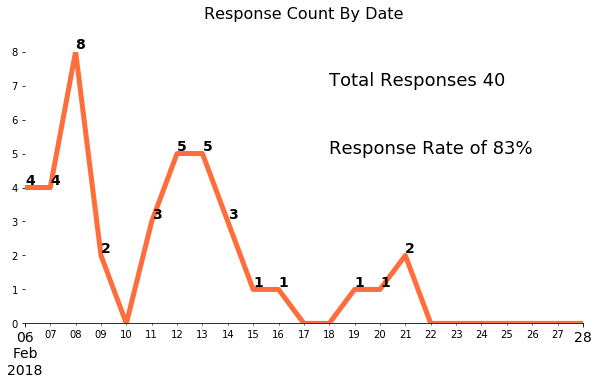

In [9]:
responses = survey['Response Date'].value_counts().reindex(pd.date_range('2/6/2018', periods=28, freq='D'),fill_value=0)
fig = plt.figure(figsize=(10,5))
plt.title('Response Count By Date',size=16,y=1.1)
responses.plot(linewidth=5.0,color='#ff6d3b')
plt.xlim(('2/6/2018','2/28/2018'))
plt.ylim((0,8))
plt.tick_params(axis='x',labelsize=14,rotation=False)
sns.despine(top=True,right=True, left=True)
for d, v in responses.items():
    if(v > 0):
        plt.text(d,v+.1,v,fontweight='bold',fontsize=14)
plt.text(17580,7,str('Total Responses ') + str("{0:.0f}".format(responses.sum())),fontsize=18)
plt.text(17580,5,str('Response Rate of ') + str("{0:.0f}%".format((responses.sum()/48)*100)),fontsize=18)

We had a total of 40 responses from the 50 Buyers who received the survey. Making our response rate 83% on the survey which is pretty great! We received 95% of all responses in the first 2 weeks. 

# High Level Health Check
Checking the total responses for the questions "This Process is Easy" and "This Process is Effective"

In [10]:
bin_total = pd.cut(survey[survey.columns[easy_use] | survey.columns[effective]].stack(dropna=False),2, labels=["Strongly Disagree\n/Disagree", "Strongly Agree\n/Agree"]).value_counts(dropna=False).sort_index(ascending=False)
bin_total

Strongly Agree\n/Agree          1626
Strongly Disagree\n/Disagree     294
NaN                              640
dtype: int64

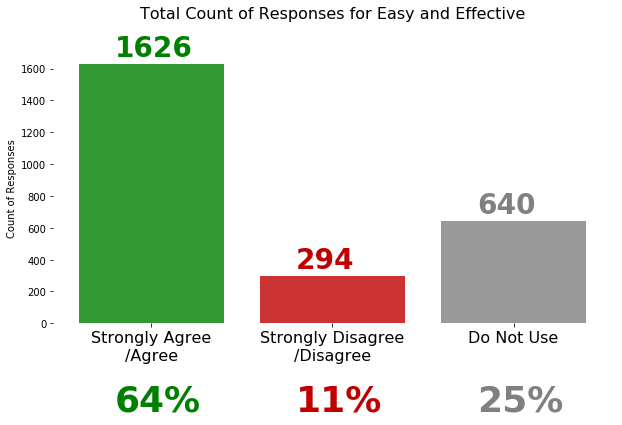

In [11]:
fig = plt.figure(figsize=(10,5))
y_pos = np.arange(len(bin_total))
com = list(bin_total.values)
plt.title('Total Count of Responses for Easy and Effective',size=16,y=1.1)
plt.bar(y_pos,com,align='center',color=['g',(192/255,0/255,0/255),'grey'],alpha=.8)
plt.xticks(y_pos, ['Strongly Agree\n/Agree','Strongly Disagree\n/Disagree','Do Not Use'], rotation=90)
plt.ylabel('Count of Responses')
plt.tick_params(axis='x',labelsize=16,rotation=False)
sns.despine(top=True,right=True,bottom=True, left=True)
c_l = ['g',(192/255,0/255,0/255),'grey']
for i, v in enumerate(bin_total):
    plt.text(i-.2,v+50, v, color=c_l[i],fontweight='bold',fontsize=28)
    plt.text(i-.2,-550,"{0:.0f}%".format((v / bin_total.values.sum())*100),color=c_l[i],fontweight='bold',fontsize=36)

Based on initial analysis we had overwhelming positive results from the survey with positive responses racking in at 64% and negative only at 11%. This indicates we are healthy from a process standpoint. 

One thing that stood out is the high responses of Do Not Use. This shows the uniqueness among each of the Buyer's role as I suspect that no process was not use by any Buyer. 

# How Often Each Process is Used
***
Finding out which processes are our "core" processes and which processes we don't use that often. This will be valuable to know as we look into which processes are the easiest and most effective.

In [12]:
often_q = survey[survey.columns[how_often]]
often_q.columns = [str(x)[:-8] for x in list(often_q.columns)]

In [13]:
def generate_heat_map(data,column_map,color):
    d = dict(selector="th",
        props=[('text-align', 'center'),("font-size", "8pt")])
    cm = sns.light_palette(color, as_cmap=True)
    hm = data.apply(pd.Series.value_counts)
    hm = hm.transpose().fillna(0)
    hm = hm.rename(index=str,columns=column_map)
    hm = hm.apply(lambda x : 100*(x/x.sum()),axis=1)
    hm = hm.style.background_gradient(cm, axis=1)\
        .set_properties(**{'width':'6em', 'text-align':'center','font-weight': 'bold', 'font-size': '8pt'})\
        .set_table_styles([d])
    return hm
    
generate_heat_map(often_q,{0:'Never',1:'Once Per Quarter',2:'2-3x/Quarter',3:'Weekly',4:'Daily'},(255/255,109/255,59/255))

Above is a heatmap of how often each process was used expressed as a percentage. Can't really see a pattern here, but will be good reference as we go forward. One thing caught my eye here is that 5% of Buyers said they never use Purchase Order Management. This should be the main tool in there job. Lets isolate find out who they are.

In [14]:
pd.options.display.max_columns = None

display(survey[survey['Process 2 - Often'] == 0])

Response ID Response Date  Process 1 - Often  Process 1 - Easy  \
11    152423883    2018-02-08                  0               NaN   
33    152429536    2018-02-14                  0               NaN   

    Process 1 - Effective             Process 1 - Improve Comment  \
11                    NaN                                     NaN   
33                    NaN  Not used in job, sorry not inputs here   

    Process 2 - Often  Process 2 - Easy  Process 2 - Effective  \
11                  0               NaN                    NaN   
33                  0               NaN                    NaN   

               Process 2 - Improve Comment  Process 3 - Often  \
11                                     NaN                  0   
33  Not used in job, sorry not inputs here                  0   

    Process 3 - Easy  Process 3 - Effective  \
11               NaN                    NaN   
33               NaN                    NaN   

               Process 3 - Improve Comment  Process 4 - Often  \
11                                     NaN                  0   
33  Not used in job, sorry not inputs here                  1   

    Process 4 - Easy  Process 4 - Effective Process 4 - Improve Comment  \
11               NaN                    NaN                         NaN   
33               3.0                    3.0              keeps the same   

    Process 5 - Often  Process 5 - Easy  Process 5 - Effective  \
11                  0               NaN                    NaN   
33                  0               3.0                    NaN   

   Process 5 - Improve Comment  Process 6 - Often  Process 6 - Easy  \
11                         NaN                  0               NaN   
33              keeps the same                  0               NaN   

    Process 6 - Effective             Process 6 - Improve Comment  \
11                    NaN                                     NaN   
33                    NaN  Not used in job, sorry not inputs here   

    Process 7 - Often  Process 7 - Easy  Process 7 - Effective  \
11                  0               NaN                    NaN   
33                  0               NaN                    NaN   

               Process 7 - Improve Comment  Process 8 - Often  \
11                                     NaN                  2   
33  Not used in job, sorry not inputs here                  2   

    Process 8 - Easy  Process 8 - Effective Process 8 - Improve Comment  \
11               3.0                    3.0                         NaN   
33               3.0                    3.0                 good to use   

    Process 9 - Often  Process 9 - Easy  Process 9 - Effective  \
11                  0               NaN                    NaN   
33                  0               NaN                    3.0   

   Process 9 - Improve Comment  Process 10 - Often  Process 10 - Easy  \
11                         NaN                   0                NaN   
33             not used in job                   0                3.0   

    Process 10 - Effective            Process 10 - Improve Comment  \
11                     NaN                                     NaN   
33                     3.0  Not used in job, sorry not inputs here   

    Process 11 - Often  Process 11 - Easy  Process 11 - Effective  \
11                   0                NaN                     NaN   
33                   0                3.0                     3.0   

              Process 11 - Improve Comment  Process 12 - Often  \
11                                     NaN                   0   
33  Not used in job, sorry not inputs here                   0   

    Process 12 - Easy  Process 12 - Effective  \
11                NaN                     NaN   
33                3.0                     3.0   

              Process 12 - Improve Comment  Process 13 - Often  \
11                                     NaN                   1   
33  Not used in job, sorry not inputs here                   1   



The first answer someone went through and just selected 0 for all their answers except for Indirect Procurement. So this is probably an old Buyer who now is in a new role and only uses iProcurement for laptop request / etc. 

The other responses were focused on Planning and Reporting so this is likely a previous Buyer who is now a Planner

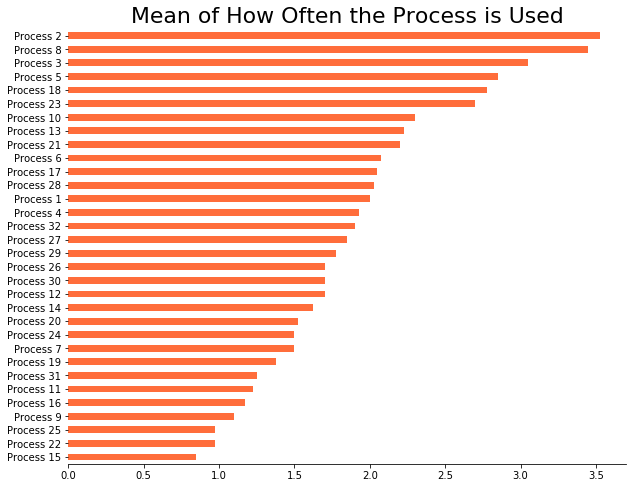

In [15]:
often_mean = often_q.mean().sort_values(ascending=True)
fig = plt.figure(figsize=(10,8))
plt.title('Mean of How Often the Process is Used',fontsize=22)
plt.tick_params(bottom="off", top="off", left="off", right="off")
sns.despine(left=True)
plt.tick_params(axis='y',labelsize=10)
often_mean.plot.barh(color='#ff6d3b')

Big drop off after top 6 so this tells us the top 6 are our "core processes". The bottom 6 processes are related mainly to Suppliers or processes only done once per quarter.

# How Easy Are Our Processes?
***
Understanding how easy each process is perceived will help us understand if our core processes are perceived as easy (hopefully they are!) and if we have any opportunities for training. First want to understand how each process ranked by taking a mean for the responses on whether respondents agreed the process was easy or not.

Processes used a lot that are not perceived as easy are the training opportunities we will want to pursue

In [16]:
#Creating a dataframe of just the Easy Questions.
easy_q = survey[survey.columns[easy_use]]
easy_q.columns = [str(x)[:-7] for x in list(easy_q.columns)]

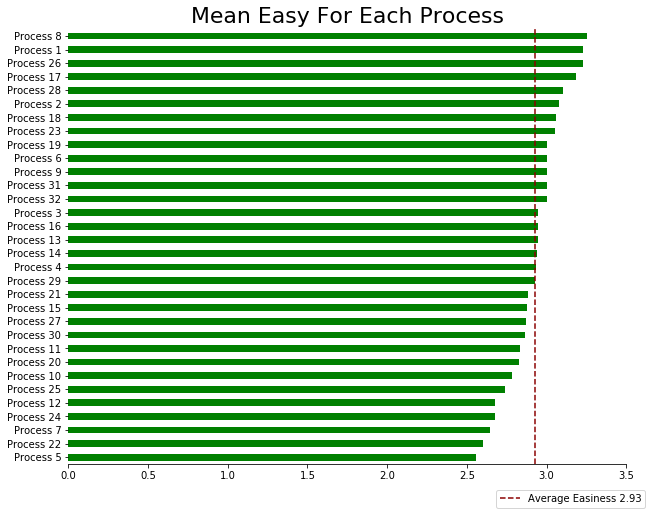

In [17]:
#Take the mean for each process. Graph the mean of each process and the average to see how each process stacks

easy_q_mean = easy_q.mean().sort_values(ascending=True)
easy_q_avg = float("{0:.2f}".format(easy_q_mean.mean()))
fig = plt.figure(figsize=(10,8))
plt.title('Mean Easy For Each Process',fontsize=22)
plt.tick_params(bottom="off", top="off", left="off", right="off")
plt.axvline(x=easy_q_avg, linestyle='--', color='darkred', label='Average Easiness ' + str(easy_q_avg))
sns.despine(left=True)
plt.xlim(0,3.5)
easy_q_mean.plot.barh(color='g',label='__nolegend__')
plt.legend(bbox_to_anchor=(.9, -.08),loc=10)

Processes seen as easy were mostly quick and transactional. Processes seen as hard (or not easy) were more in depth processes based on this graph.

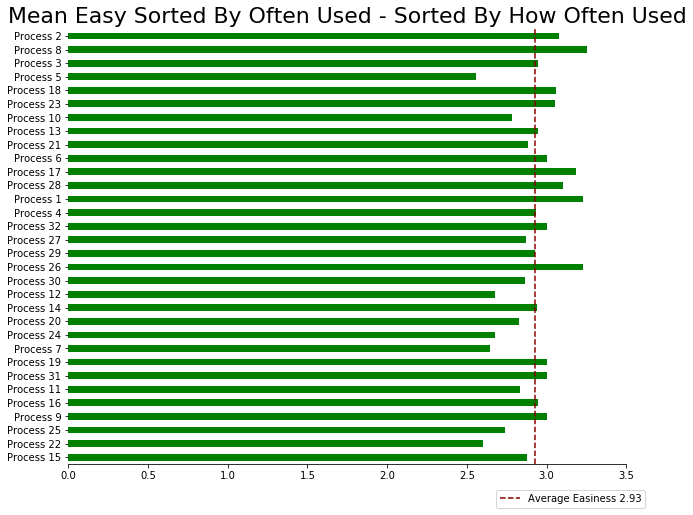

In [18]:
easy_by_often = easy_q.mean().reindex(often_mean.index)
easy_often_avg = float("{0:.2f}".format(easy_by_often.mean()))
fig = plt.figure(figsize=(10,8))
plt.title('Mean Easy Sorted By Often Used - Sorted By How Often Used',fontsize=22)
plt.tick_params(bottom="off", top="off", left="off", right="off")
plt.axvline(x=easy_q_avg, linestyle='--', color='darkred', label='Average Easiness ' + str(easy_often_avg))
sns.despine(left=True)
plt.xlim(0,3.5)
easy_by_often.plot.barh(color='g',label='__nolegend__')
plt.legend(bbox_to_anchor=(.9, -.08),loc=10)

There are some solid opportunities for training in the upper half portion of the bar graph. We can see that ASCP HP and RTVs falls under the average easiness. The rest below average are in the bottom half of the graph meaning that processes that we use less often are seen as not as easy to use.

This is either due to users not having a lot of exposures to the process or they are not well refined processes. These will require deep dives to understand which it is.

## Count and Distribution of Respones for Easy to Use

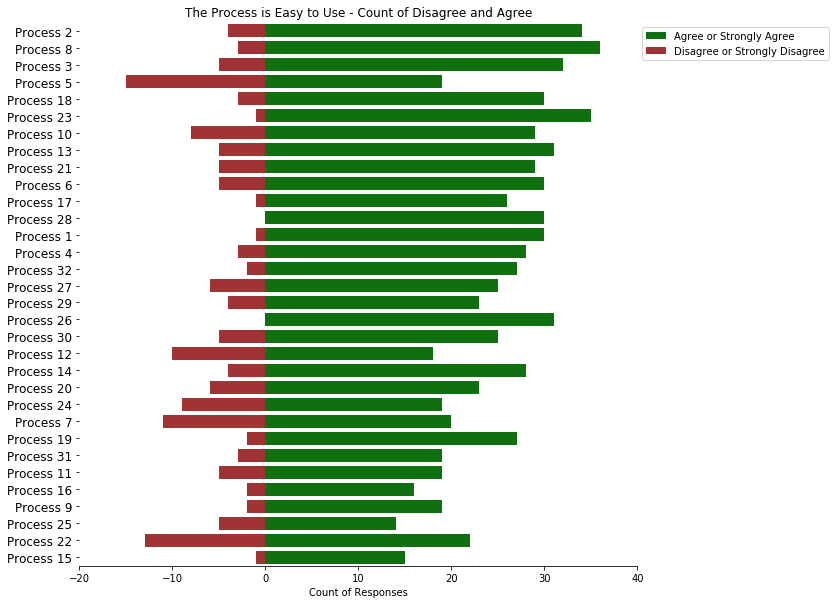

In [19]:
x1 = -(easy_q[easy_q <= 2].count())
x2 = easy_q[easy_q >= 3].count()
y = x1.index

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
ax= sns.barplot(x=x2,y=y,color='g',label='Agree or Strongly Agree', order=list(often_mean.index)[::-1])
ax = sns.barplot(x=x1, y=y,color=(178/255,34/255,34/255), label='Disagree or Strongly Disagree', order=list(often_mean.index)[::-1])
ax.set_title('The Process is Easy to Use - Count of Disagree and Agree')
ax.tick_params(axis='y',labelsize=12)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel('Count of Responses')
plt.xlim(-20,40)
sns.despine(left=True, right=True)



## Scatter of How Often Used and Easy Process
To explore which processes we should target training for further. Lets scatter each of our processes with How Often used on the Y axis and The Process is Easy on the X axis.

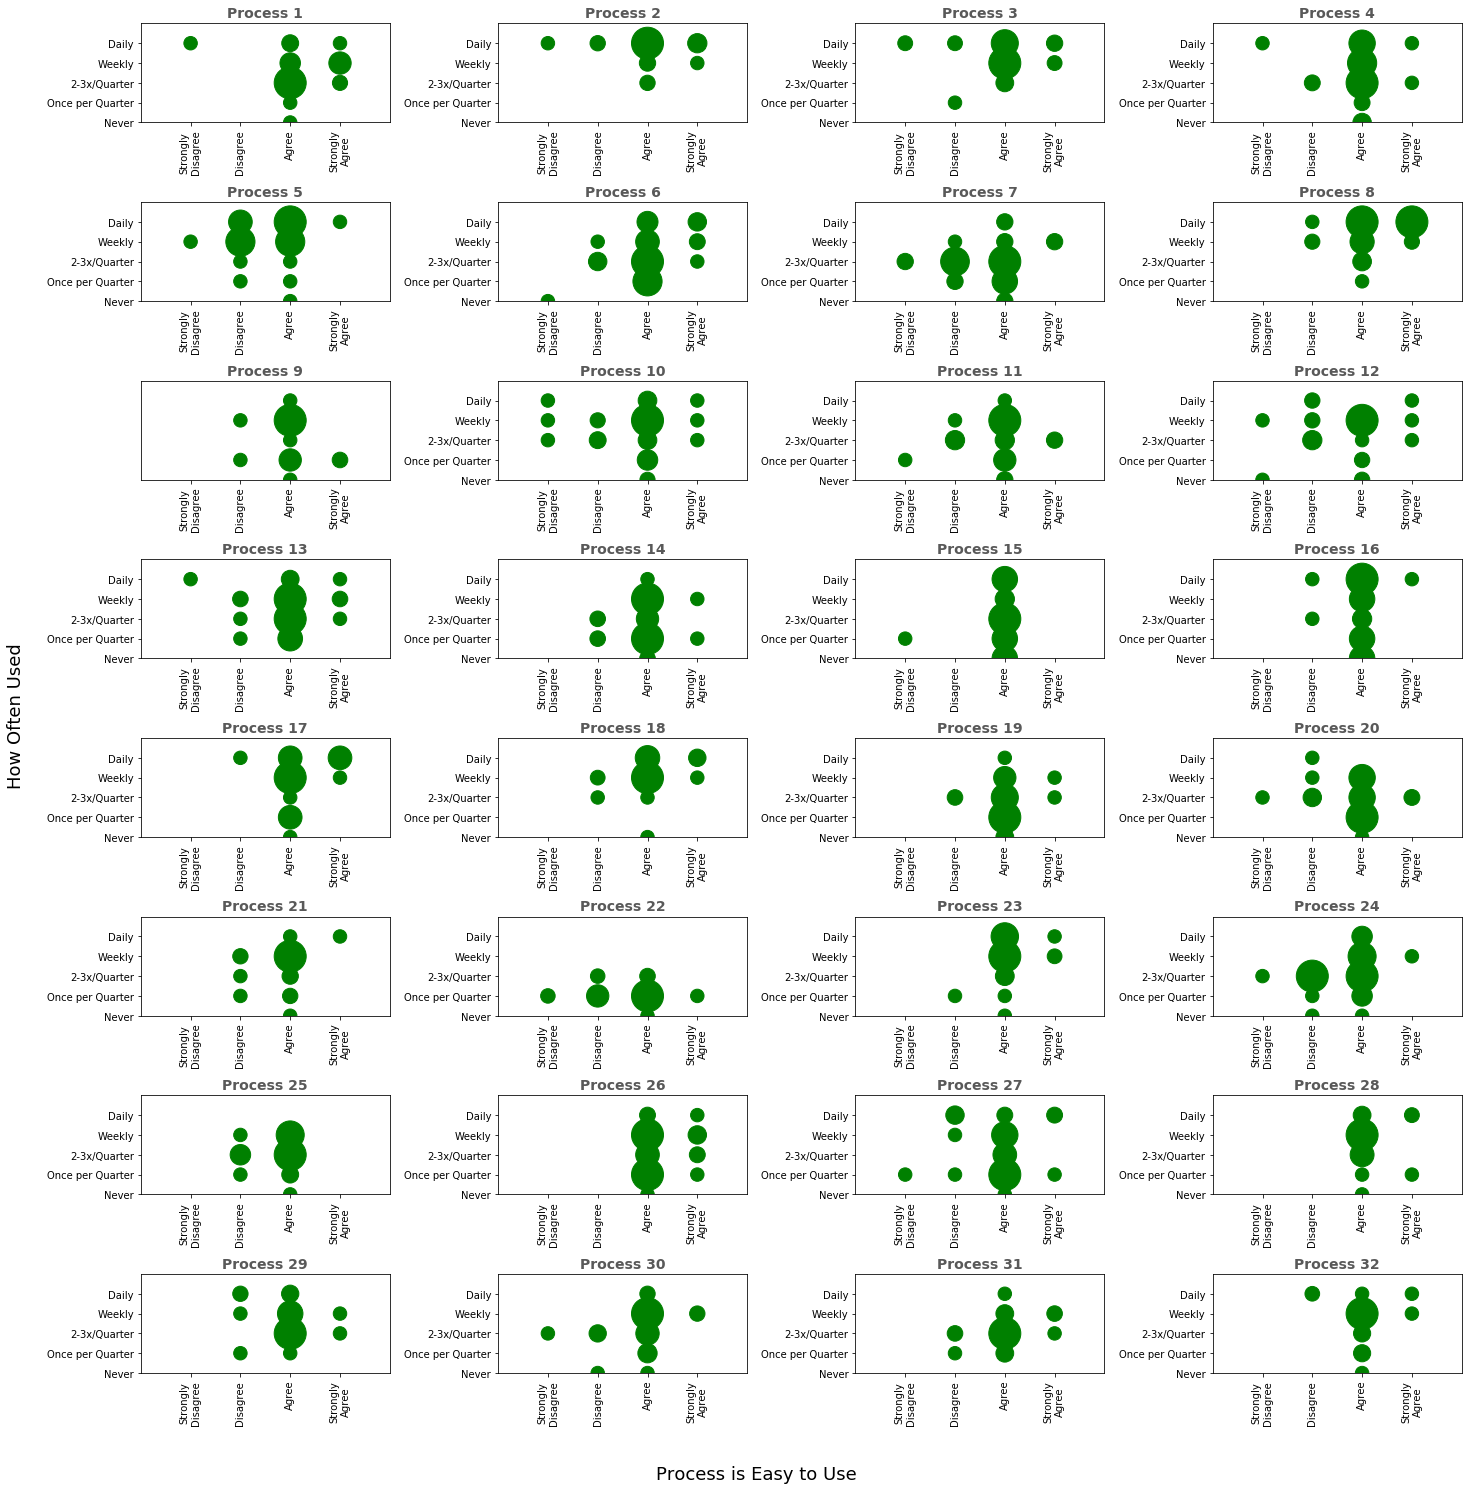

In [20]:
fig = plt.figure(figsize=(20,20))

x = 0

for col in easy_q.columns:
    a = easy_q[col]
    b = survey.iloc[:,how_often[x]]
    
    u, c = np.unique(np.c_[a,b], return_counts=True, axis=0)
    s = lambda y : (((y-y.min())/float(y.max()-y.min())+1)*8)**2.5
    
    ax = fig.add_subplot(8,4,x+1)
    ax.set_title(col, fontsize=14, fontweight='bold', color=(89/255,89/255,89/255))
    if x == 8:
        ax.axes.get_yaxis().set_visible(False)
    ax = plt.scatter(u[:,0],u[:,1],s=s(c), alpha=1,c='Green')
    plt.xticks([1,2,3,4],['Strongly\nDisagree','Disagree','Agree','Strongly\nAgree'],rotation='vertical')
    plt.yticks([0,1,2,3,4],['Never', 'Once per Quarter','2-3x/Quarter','Weekly','Daily'])
    plt.xlim((0,5))
    plt.ylim((0,5))
    x += 1
fig.text(.5, -0.03, 'Process is Easy to Use', ha='center',fontsize=18)
fig.text(-0.02, 0.5, 'How Often Used', va='center', rotation='vertical',fontsize=18)
plt.tight_layout()

## Easy / Often Used Ratio
To find out which processes were used the most and rated the lowest I will create a ratio between Used Mean and Rated Mean. 
This ratio puts equal weights to how often used and how easy. 

In [21]:
unsort_easy_mean = easy_q.mean().reset_index()
unsort_often_mean = often_q.mean().reset_index()
ratio = pd.DataFrame({'Process' : columns,
                      'Ratio' : unsort_often_mean[0] / unsort_easy_mean[0] 
                     })
ratio.sort_values(by='Ratio',ascending=False)

Process     Ratio
1    Process 2  1.144872
4    Process 5  1.113793
7    Process 8  1.059449
2    Process 3  1.035321
17  Process 18  0.906683
22  Process 23  0.883636
9   Process 10  0.826214
20  Process 21  0.763265
12  Process 13  0.755660
5    Process 6  0.691667
3    Process 4  0.655769
27  Process 28  0.653226
26  Process 27  0.644382
16  Process 17  0.643605
11  Process 12  0.634667
31  Process 32  0.633333
0    Process 1  0.620000
28  Process 29  0.606646
29  Process 30  0.593023
6    Process 7  0.567073
23  Process 24  0.560000
13  Process 14  0.553191
19  Process 20  0.539329
25  Process 26  0.527000
18  Process 19  0.458333
10  Process 11  0.432353
30  Process 31  0.416667
15  Process 16  0.399057
21  Process 22  0.375000
8    Process 9  0.366667
24  Process 25  0.356250
14  Process 15  0.295652

### Conclusion - Easiness
Based on the analysis above the processes we will target for in-depth training will be:

    Purchase Order Management

    Cloud Horizontal Plan and Exceptions

    Return to Vendors

    Requisition Management

    Inventory Aging

# Most Effective Processes
***
Running analysis to see which Processes ranked high or low on the effective scale

In [22]:
effective_q = survey[survey.columns[effective]]
effective_q.columns = [str(x)[:-12] for x in list(effective_q.columns)]

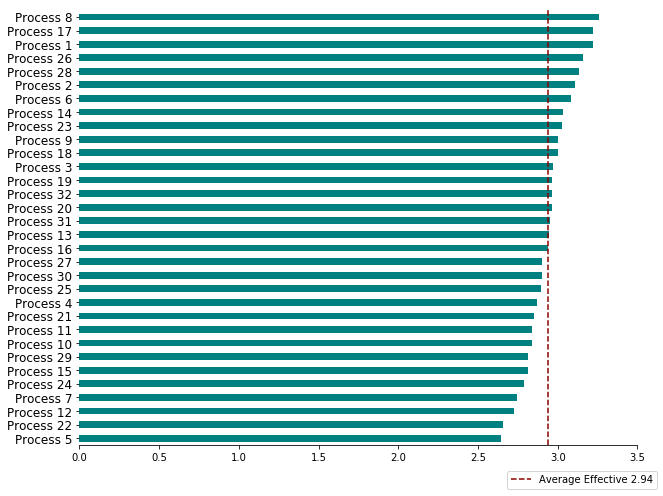

In [23]:
effective_mean = effective_q.mean().sort_values(ascending=True)
effective_avg = effective_mean.mean()
effective_avg = float("{0:.2f}".format(effective_avg))

fig = plt.figure(figsize=(10,8))
plt.tick_params(bottom="off", top="off", left="off", right="off")
plt.xlim(0,3.5)
plt.tick_params(axis='y',labelsize=12)
plt.axvline(x=effective_avg, linestyle='--', color='darkred', label='Average Effective ' + str(effective_avg))
sns.despine(left=True)
effective_mean.plot.barh(color='Teal', label='_nolegend_')
plt.legend(bbox_to_anchor=(.9, -.08),loc=10)

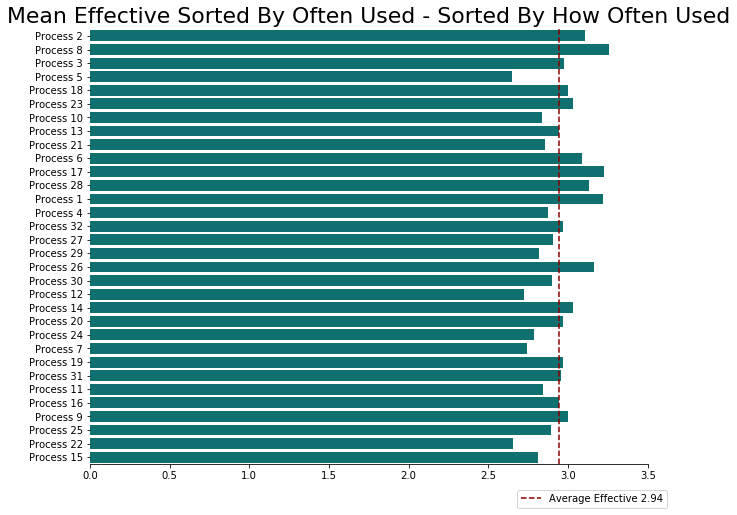

In [24]:
effective_by_often = effective_q.mean()
effective_often_avg = float("{0:.2f}".format(effective_by_often.mean()))
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(1,1,1)
ax = sns.barplot(x=effective_by_often.values,y=effective_by_often.index,color='Teal', order=list(often_mean.index)[::-1])
plt.title('Mean Effective Sorted By Often Used - Sorted By How Often Used',fontsize=22)
plt.tick_params(bottom="off", top="off", left="off", right="off")
plt.axvline(x=effective_often_avg, linestyle='--', color='darkred', label='Average Effective ' + str(effective_often_avg))
sns.despine(left=True)
plt.xlim(0,3.5)
plt.legend(bbox_to_anchor=(.9, -.08),loc=10)

### Conclusion - Effectiveness
Based on the analysis above the effective responses are nearly identical to the easily used answers. We will deep dive into correlations later, but we appear to be getting the same results from these. You can view more analysis on effective in the appendix. The processes we want in-depth training on we will also want to deep-dive and explore other solutions for.

    Purchase Order Management

    Cloud Horizontal Plan and Exceptions

    Return to Vendors

    Requisition Management

    Inventory Aging

# Buyer Comments on Processes
***
Lets see which comments had the most comments

In [25]:
pd.options.display.max_colwidth = 650
improve_q = survey[survey.columns[improve]]
improve_q_c = improve_q.count().sort_values(ascending=False)
x = list(improve_q_c.index)
x[:] = [str(l)[:-18] for l in x]

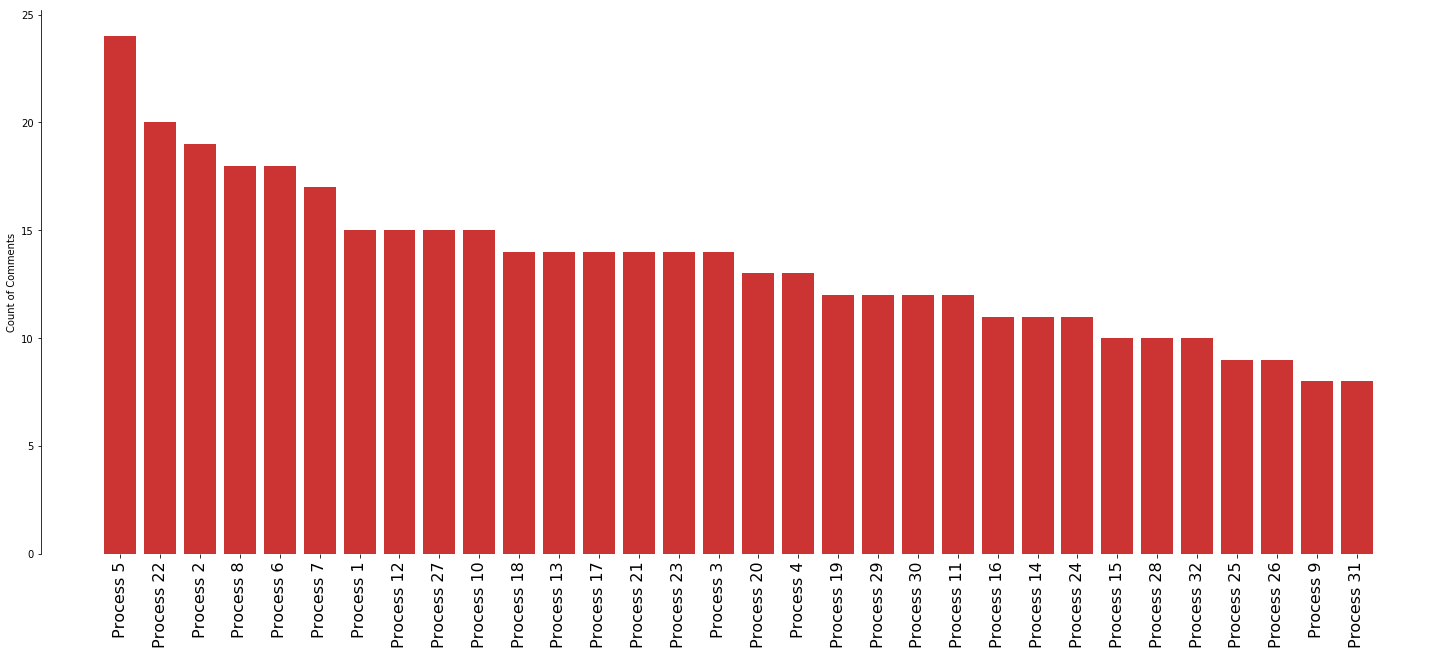

In [26]:
fig = plt.figure(figsize=(25,10))
y_pos = np.arange(len(x))
com = list(improve_q_c.values)
plt.bar(y_pos,com,align='center',color=(192/255,0/255,0/255),alpha=.8)
plt.xticks(y_pos, x, rotation=90)
plt.ylabel('Count of Comments')
plt.tick_params(axis='x',labelsize=16)
sns.despine(top=True,right=True,bottom=True)

Processes which are not easy had the most comments. We can use these comments when we develop training and deep dive onto process

## Comment Table

In [27]:
#improve_q.to_csv('CrossFit Improve Comments.csv', index=False)
for row in improve_q:
    print('\033[1m' + str(row) + '\n' + '\033[0m')
    for ans in improve_q[row]:
        if ans is not np.nan:
            print('-' + str(ans) + '\n')

Process 1 - Improve Comment

-The ability to modify an MT after submission would be great. Also, clearer explanation of which form to use for which type of transaction (MT, OOS, direct expense MT, etc)

-I was referring to Vendor Sale process, working really good

-The MT process covers multiple types of transfers. The templates should be editable. Sometimes it is a small typo and you have to recreate the form.

-For RTV's, will be more efficient if PO #, part info/locator, and supplier ship to address are linked from GSI, so buyers don't need to enter the info manually.

-unsure

-I'd suggest that buyer can upload excel template instead of fill in too much information step by step.

-nothing

-Perform the transaction promptly

-My Buyers team have done this survey with their inputs

-Good~No suggestion for improvement

-Some times we struggle with which alias to use. Some times we need to ping folks on the movement of material from location to location

-For RTV/SBO, ship-to address c

# Viewing Correlations Between the Means of Each Column
***
Lets first see how each column's mean correlates to each other.

In [28]:
#create a dataframe of each column types mean to run correlation against
com_con = improve_q.count().reset_index()
unsort_eff_mean = effective_q.mean().reset_index()

comcorr = pd.DataFrame({'Process' : columns,
                      'Easy' : unsort_easy_mean[0],
                      'Often' : unsort_often_mean[0],
                      'Effective' : unsort_eff_mean[0],
                      'Comments Count' : com_con[0]
                     })
comcorr.set_index('Process')

Comments Count      Easy  Effective  Often
Process                                               
Process 1               15  3.225806   3.218750  2.000
Process 2               19  3.078947   3.105263  3.525
Process 3               14  2.945946   2.972973  3.050
Process 4               13  2.935484   2.870968  1.925
Process 5               24  2.558824   2.647059  2.850
Process 6               18  3.000000   3.085714  2.075
Process 7               17  2.645161   2.741935  1.500
Process 8               18  3.256410   3.256410  3.450
Process 9                8  3.000000   3.000000  1.100
Process 10              15  2.783784   2.837838  2.300
Process 11              12  2.833333   2.840000  1.225
Process 12              15  2.678571   2.724138  1.700
Process 13              14  2.944444   2.944444  2.225
Process 14              11  2.937500   3.031250  1.625
Process 15              10  2.875000   2.812500  0.850
Process 16              11  2.944444   2.941176  1.175
Process 17              14  3.185185   3.222222  2.050
Process 18              14  3.060606   3.000000  2.775
Process 19              12  3.000000   2.966667  1.375
Process 20              13  2.827586   2.965517  1.525
Process 21              14  2.882353   2.852941  2.200
Process 22              20  2.600000   2.657143  0.975
Process 23              14  3.055556   3.027778  2.700
Process 24              11  2.678571   2.785714  1.500
Process 25               9  2.736842   2.894737  0.975
Process 26               9  3.225806   3.161290  1.700
Process 27              15  2.870968   2.903226  1.850
Process 28              10  3.100000   3.133333  2.025
Process 29              12  2.925926   2.814815  1.775
Process 30              12  2.866667   2.900000  1.700
Process 31               8  3.000000   2.954545  1.250
Process 32              10  3.000000   2.965517  1.900

In [29]:
corr = comcorr.corr()

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "16pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em"),('text-align','center')]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-weight', 'bold')])
]

corr.style.set_properties(**{'max-width': '100px', 'font-size': '16pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())


Processes which were Not Easy had More Comments

Processes Used More Often had More Comments

Effective and Easy are unsurprisingly heavily Positively Correlated

Processes Used More Often are found to be Easier and More Effective

# Actions Taken From Data / Next Steps
***
### Rearrange JIRA / Cloud Test Case Order
Place core processes in front of queue and ensure they get the bulk of the testing and solution in Cloud

### Use Buyer Comments to Improve Cloud Solutions
Add Buyer comments to JIRAs for each process. Use these as reference during testing for ideas on how to improve each process

### Group Trainings Based on Correlation
Run a correlation for each process to explore if there is a relationship between Buyers who struggle with process also struggle with another. Use this to group trainings for Phase 4 to target these people

### Open Source Data
Make data available to Buyers and Managers to play around with

### Run Survey Again After Cloud
To put some real numbers to how we are doing after Cloud we will run this survey again for the Cloud Processes. See where we have improved or worst off. Add in Buyer years worked and other demographic information to survey, no need to ask Easy and Effective as they are so heavily correlated

# Appendix
***

## More Views of Process is Easy Responses

### Box Plot of Easy Responses

C:\Users\anorum\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


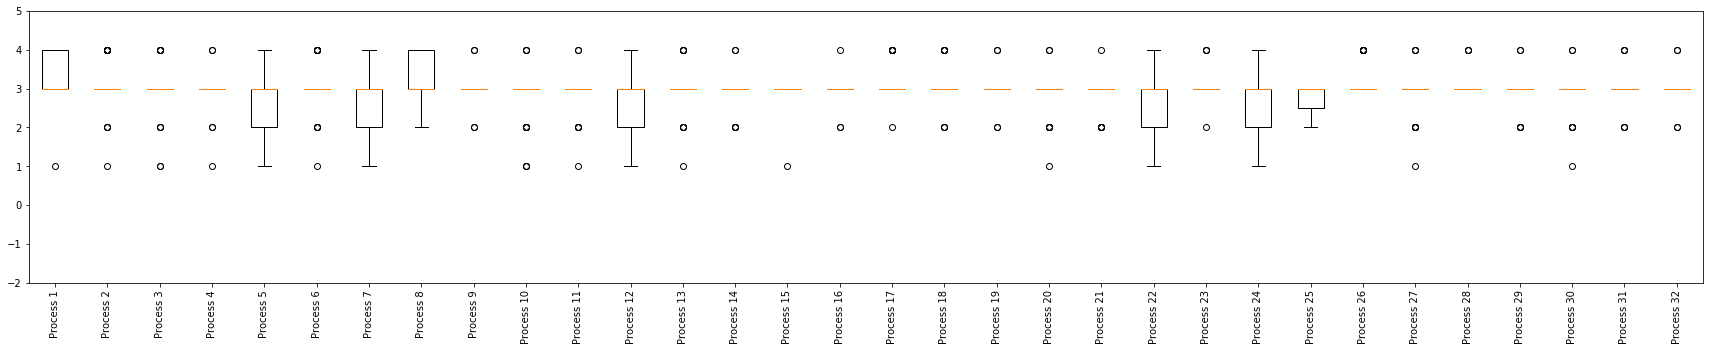

In [30]:
#Need to place in list to get rid of NaNs for boxplot below. Just substitutiong them for 0s will skew the data.
data_to_plot = []
for col in easy_q.columns:
    d = easy_q[~np.isnan(easy_q[col])][col]
    data_to_plot.append(d)

    
fig, ax = plt.subplots(figsize=(30,5))    

ax.boxplot(data_to_plot)
ax.set_xticklabels(easy_q.columns, rotation=90)
ax.set_ylim(-2,5)
plt.show()

Didn't gleam too much from this. Basically our averages for all processes fill into the 3 (Agree) for easy count . Some processes which were ranked lower on easy definitly show the distributions towards 2 and 1.

### Histogram for Easy Responeses

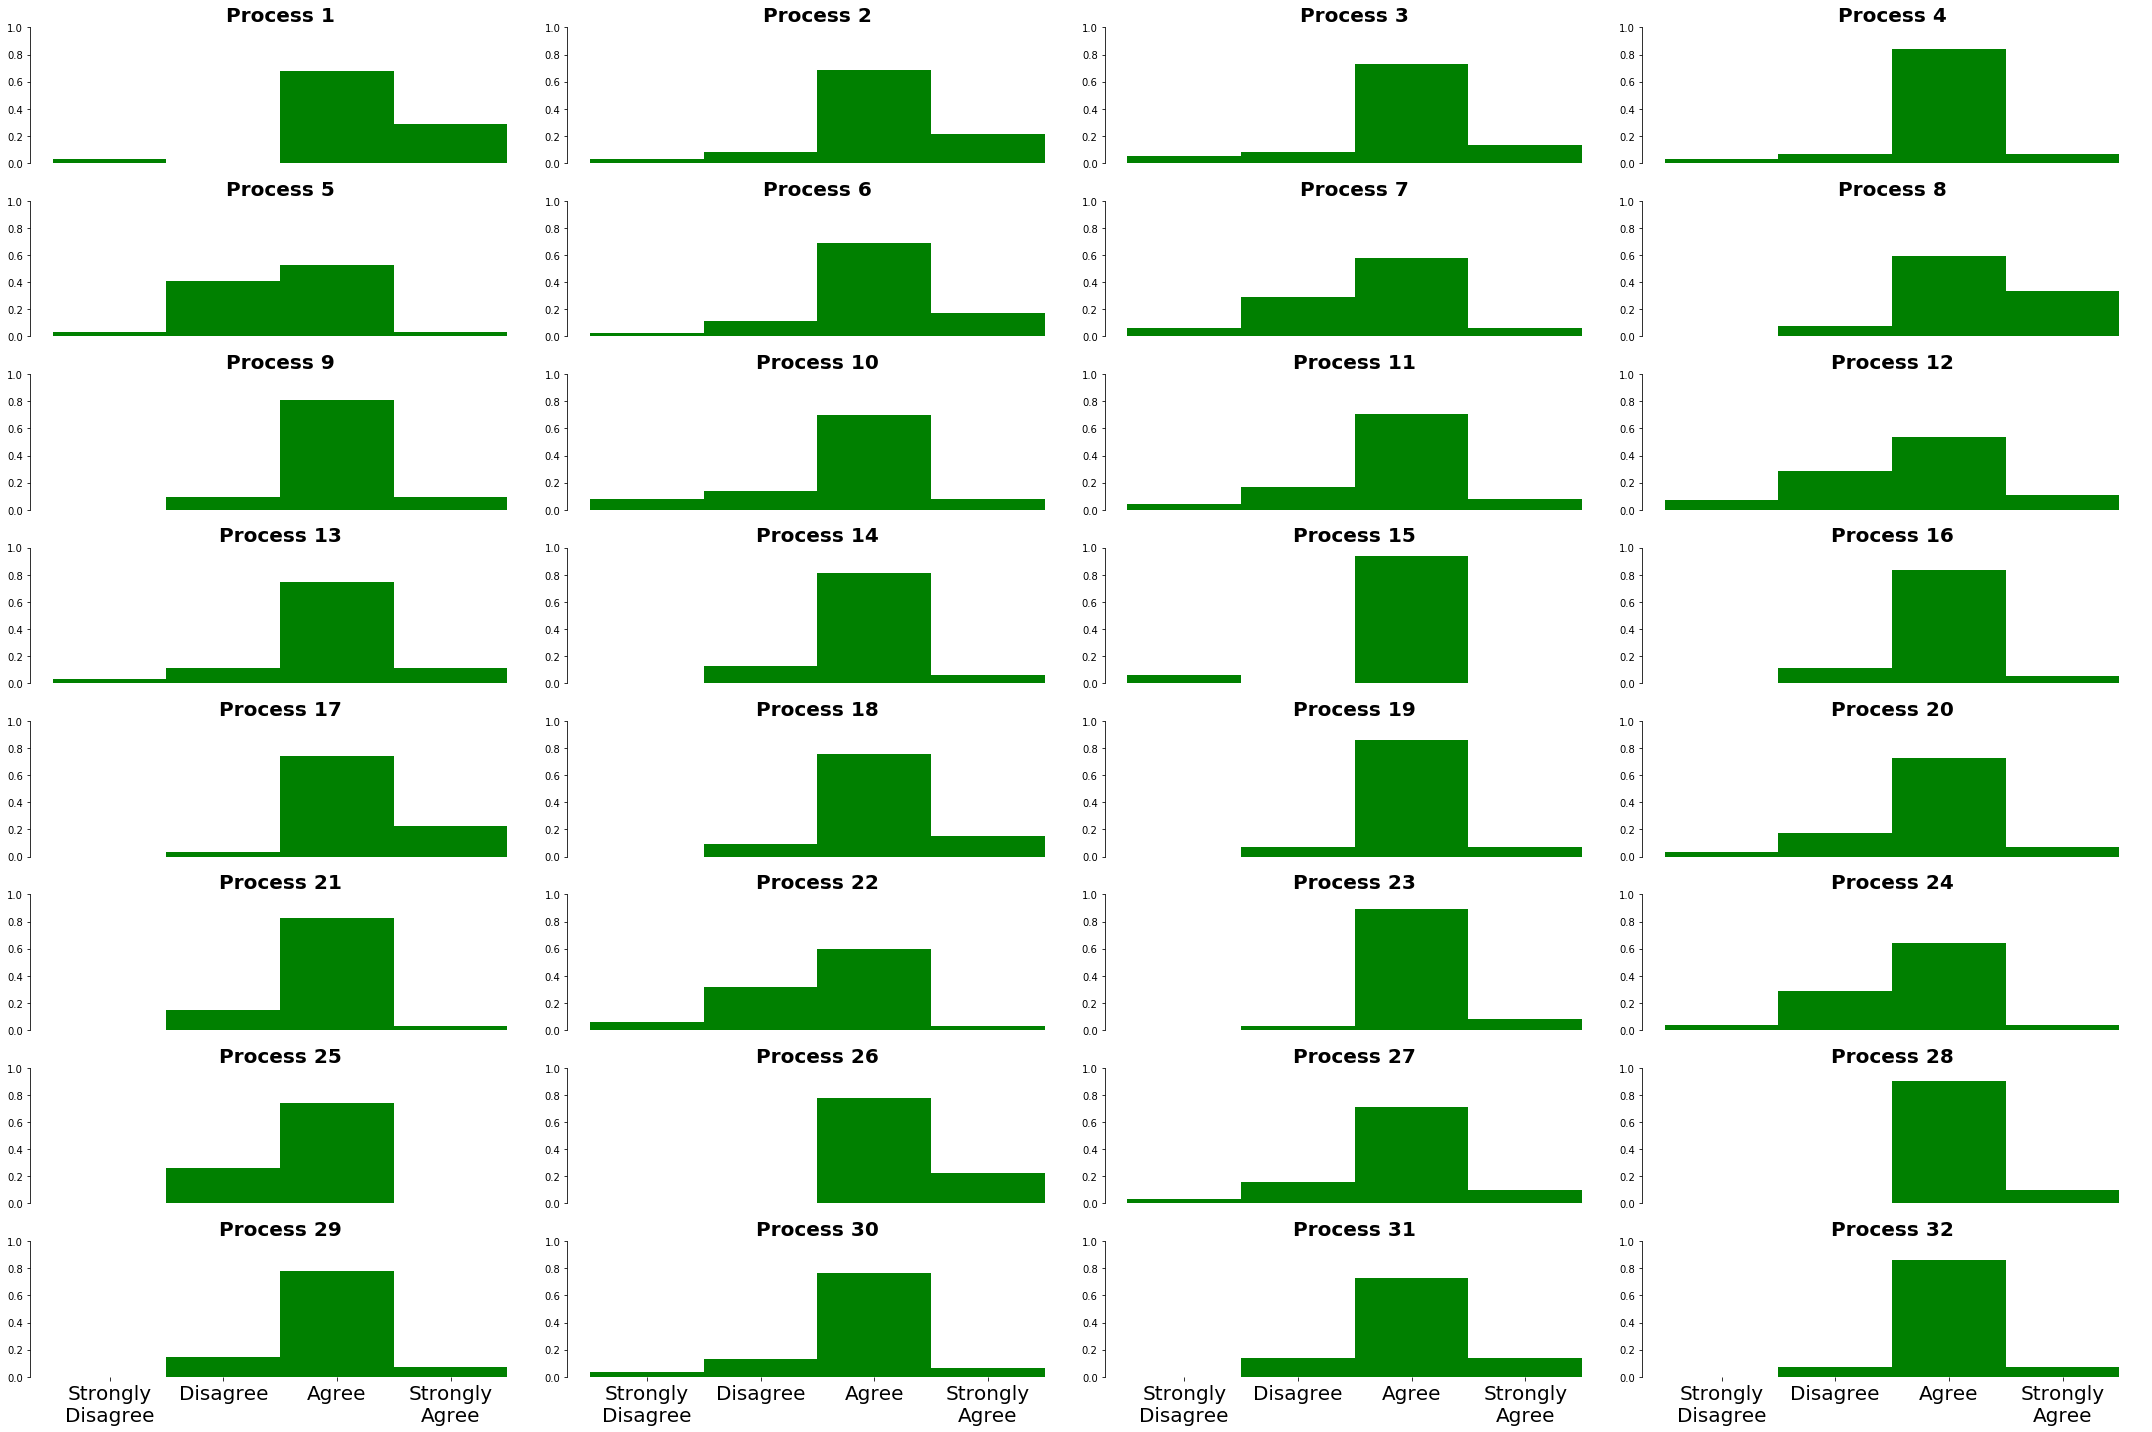

In [31]:
fig = plt.figure(figsize=(30,20))

x = 1

for col in easy_q.columns:
    ax = fig.add_subplot(8,4,x)
    d = easy_q[col].dropna()
    ax.set_ylim(0,1)
    if x < 29:
        ax.axes.get_xaxis().set_visible(False)
    ax = plt.hist(d,[1,2,3,4,5],normed=True,color='g')
    plt.title(col,fontsize='20',fontweight='bold')
    plt.xticks([1.5,2.5,3.5,4.5],['Strongly\nDisagree','Disagree','Agree','Strongly\nAgree'])
    plt.tick_params(axis='x',labelsize='20')
    sns.despine(top=True,right=True,bottom=True)
    x += 1
plt.tight_layout()

### Heat Map for Easy Responses (In Percentages)

In [32]:
generate_heat_map(easy_q,{0:'Do Not Use',1:'Strongly Disagree',2:'Disagree',3:'Agree',4:'Strongly Agree'},'green')

## More Views for Effective Responses

### Count of People Who Responded They Agree or Disagree a Process is Effective

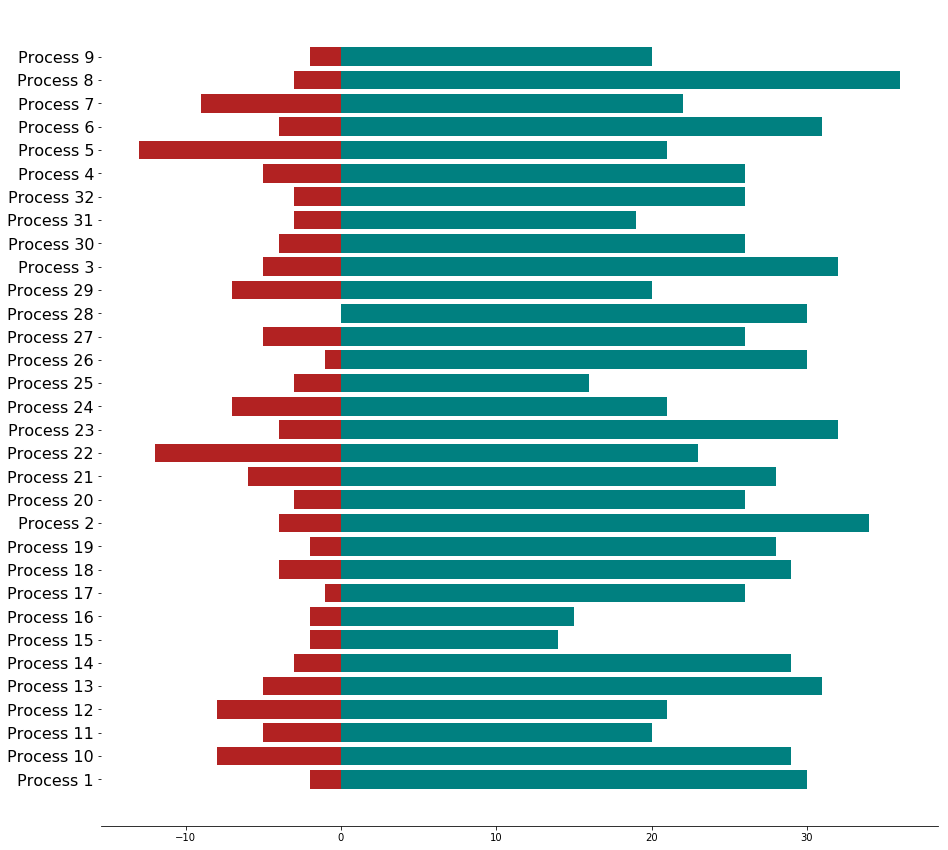

In [33]:
y = columns
x1 = -((survey[survey.columns[effective]] <= 2).sum())
x2 = (survey[survey.columns[effective]] >= 3).sum()

fig = plt.figure(figsize=(15,15))
ax = plt.subplot(111)
ax.barh(y, x2, color='Teal')
ax.barh(y, x1, color=(178/255,34/255,34/255))
ax.tick_params(axis='y',labelsize=16)
sns.despine(left=True, right=True)

### Scatter Plot of How Often Used and Effectiveness

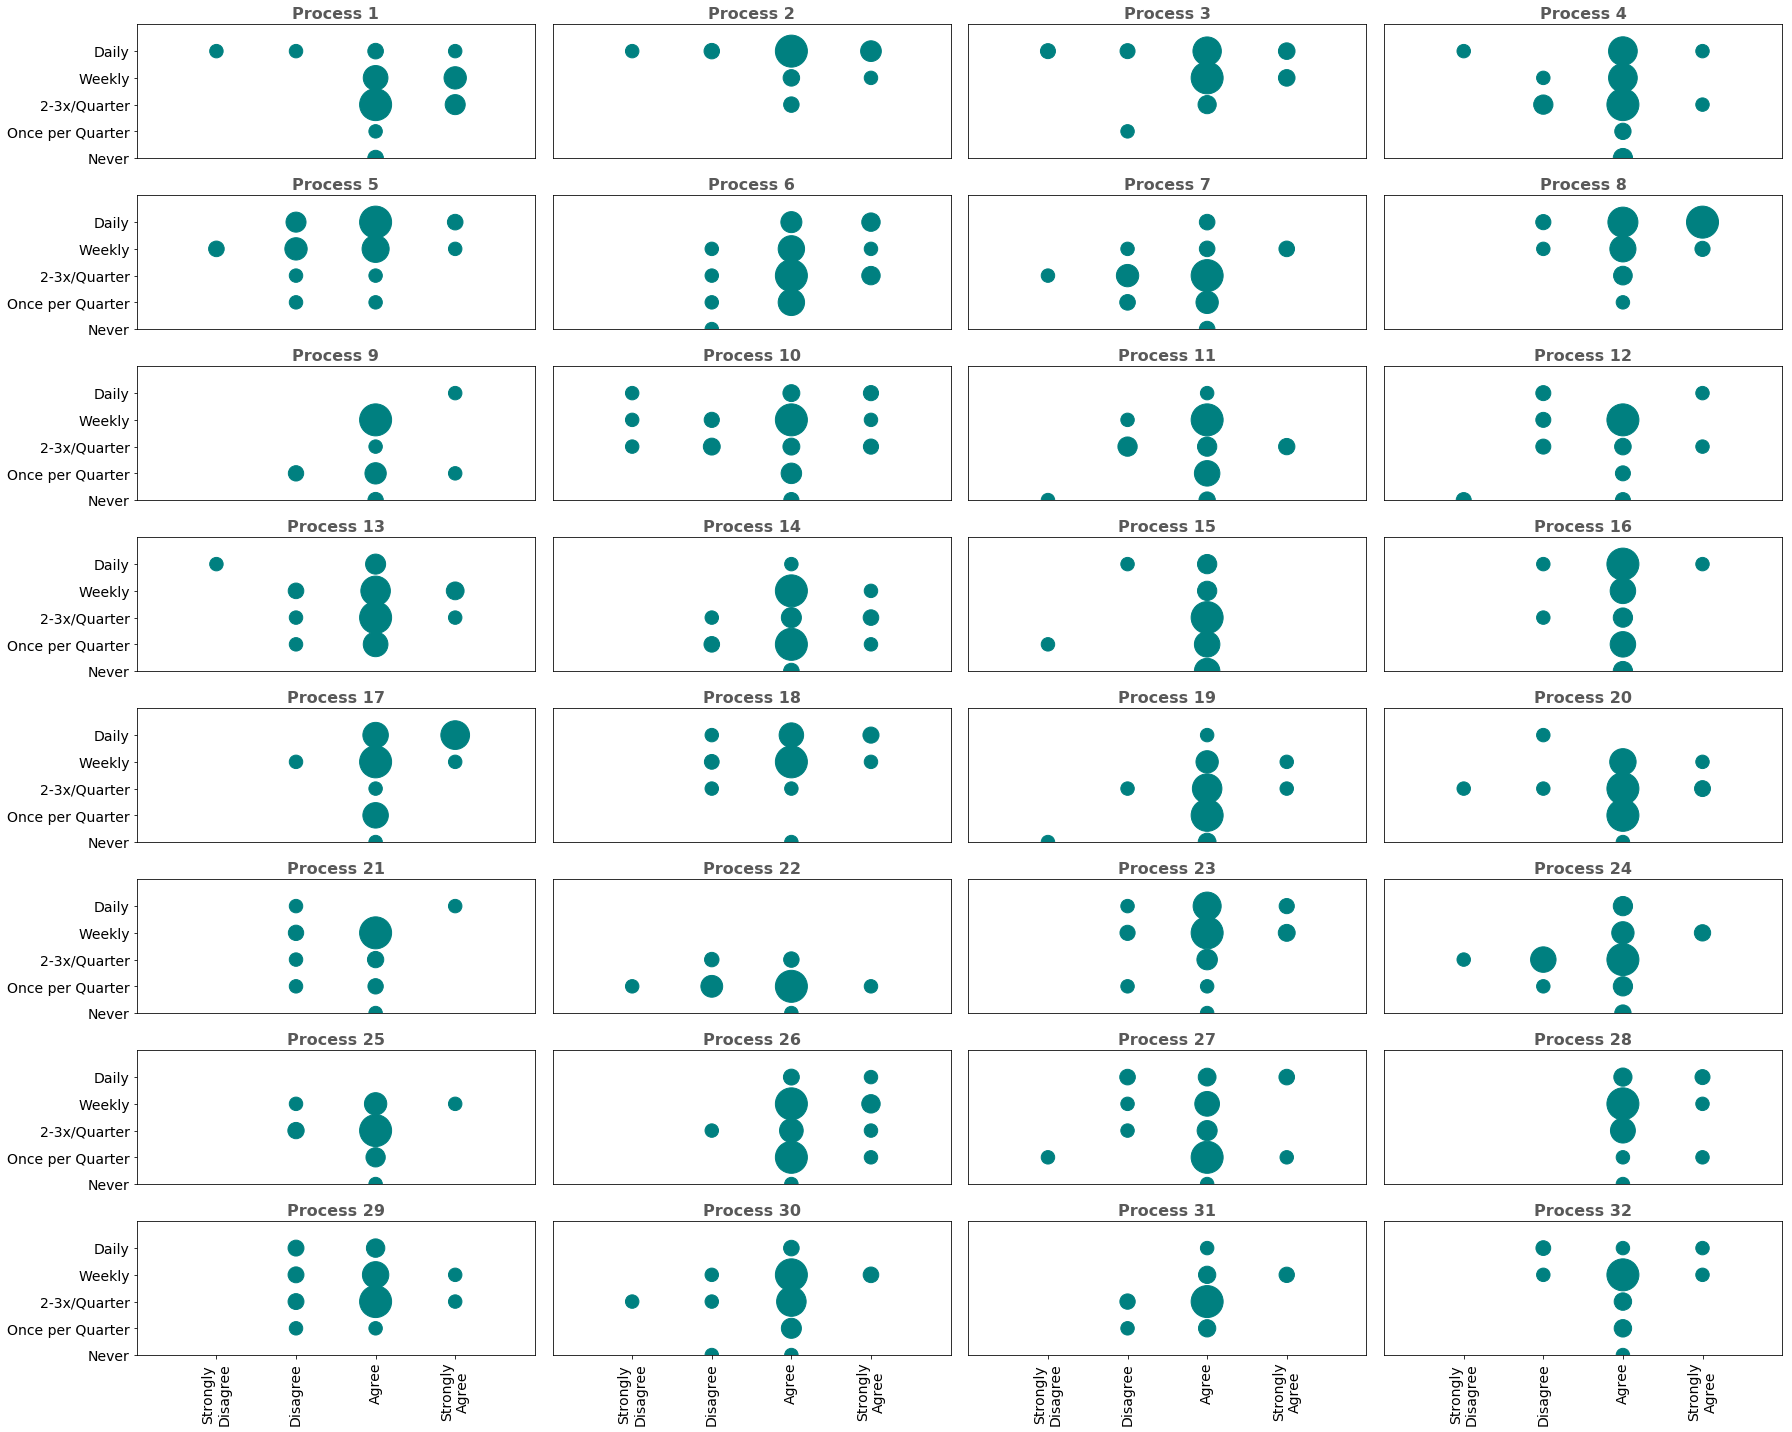

In [34]:
fig = plt.figure(figsize=(25,20))

x = 0

for col in effective_q.columns:
    a = effective_q[col]
    b = survey.iloc[:,how_often[x]]
    
    u, c = np.unique(np.c_[a,b], return_counts=True, axis=0)
    s = lambda y : (((y-y.min())/float(y.max()-y.min())+1)*8)**2.5
    ax = fig.add_subplot(8,4,x+1)
    ax.set_title(col, fontsize=16, fontweight='bold', color=(89/255,89/255,89/255))
    if x < 28:
        ax.axes.get_xaxis().set_visible(False)
    if x not in range(0,32,4):
        ax.axes.get_yaxis().set_visible(False)
    ax = plt.scatter(u[:,0],u[:,1],s=s(c), alpha=1,c='Teal')
    plt.xticks([1,2,3,4],['Strongly\nDisagree','Disagree','Agree','Strongly\nAgree'],rotation='vertical',size=14)
    plt.yticks([0,1,2,3,4],['Never', 'Once per Quarter','2-3x/Quarter','Weekly','Daily'],size=14)
    plt.xlim((0,5))
    plt.ylim((0,5))
    x += 1
plt.tight_layout()

### Box Plot for Effectiveness for each Process.
Which processes ranged the highest between Buyers would rated them Effective vs Non-Effective

C:\Users\anorum\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


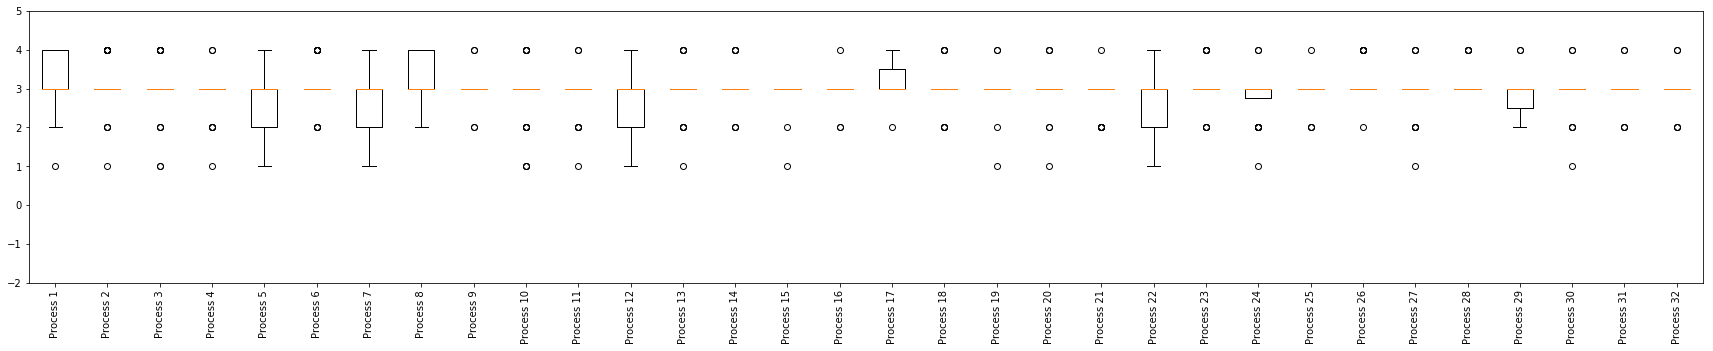

In [35]:
data_to_plot_eff = []
for col in effective_q.columns:
    d = effective_q[~np.isnan(effective_q[col])][col]
    data_to_plot_eff.append(d)

    
fig, ax = plt.subplots(figsize=(30,5))    

ax.boxplot(data_to_plot_eff)
ax.set_xticklabels(effective_q.columns, rotation=90)
ax.set_ylim(-2,5)
plt.show()

## Effective Histogram for Each Process

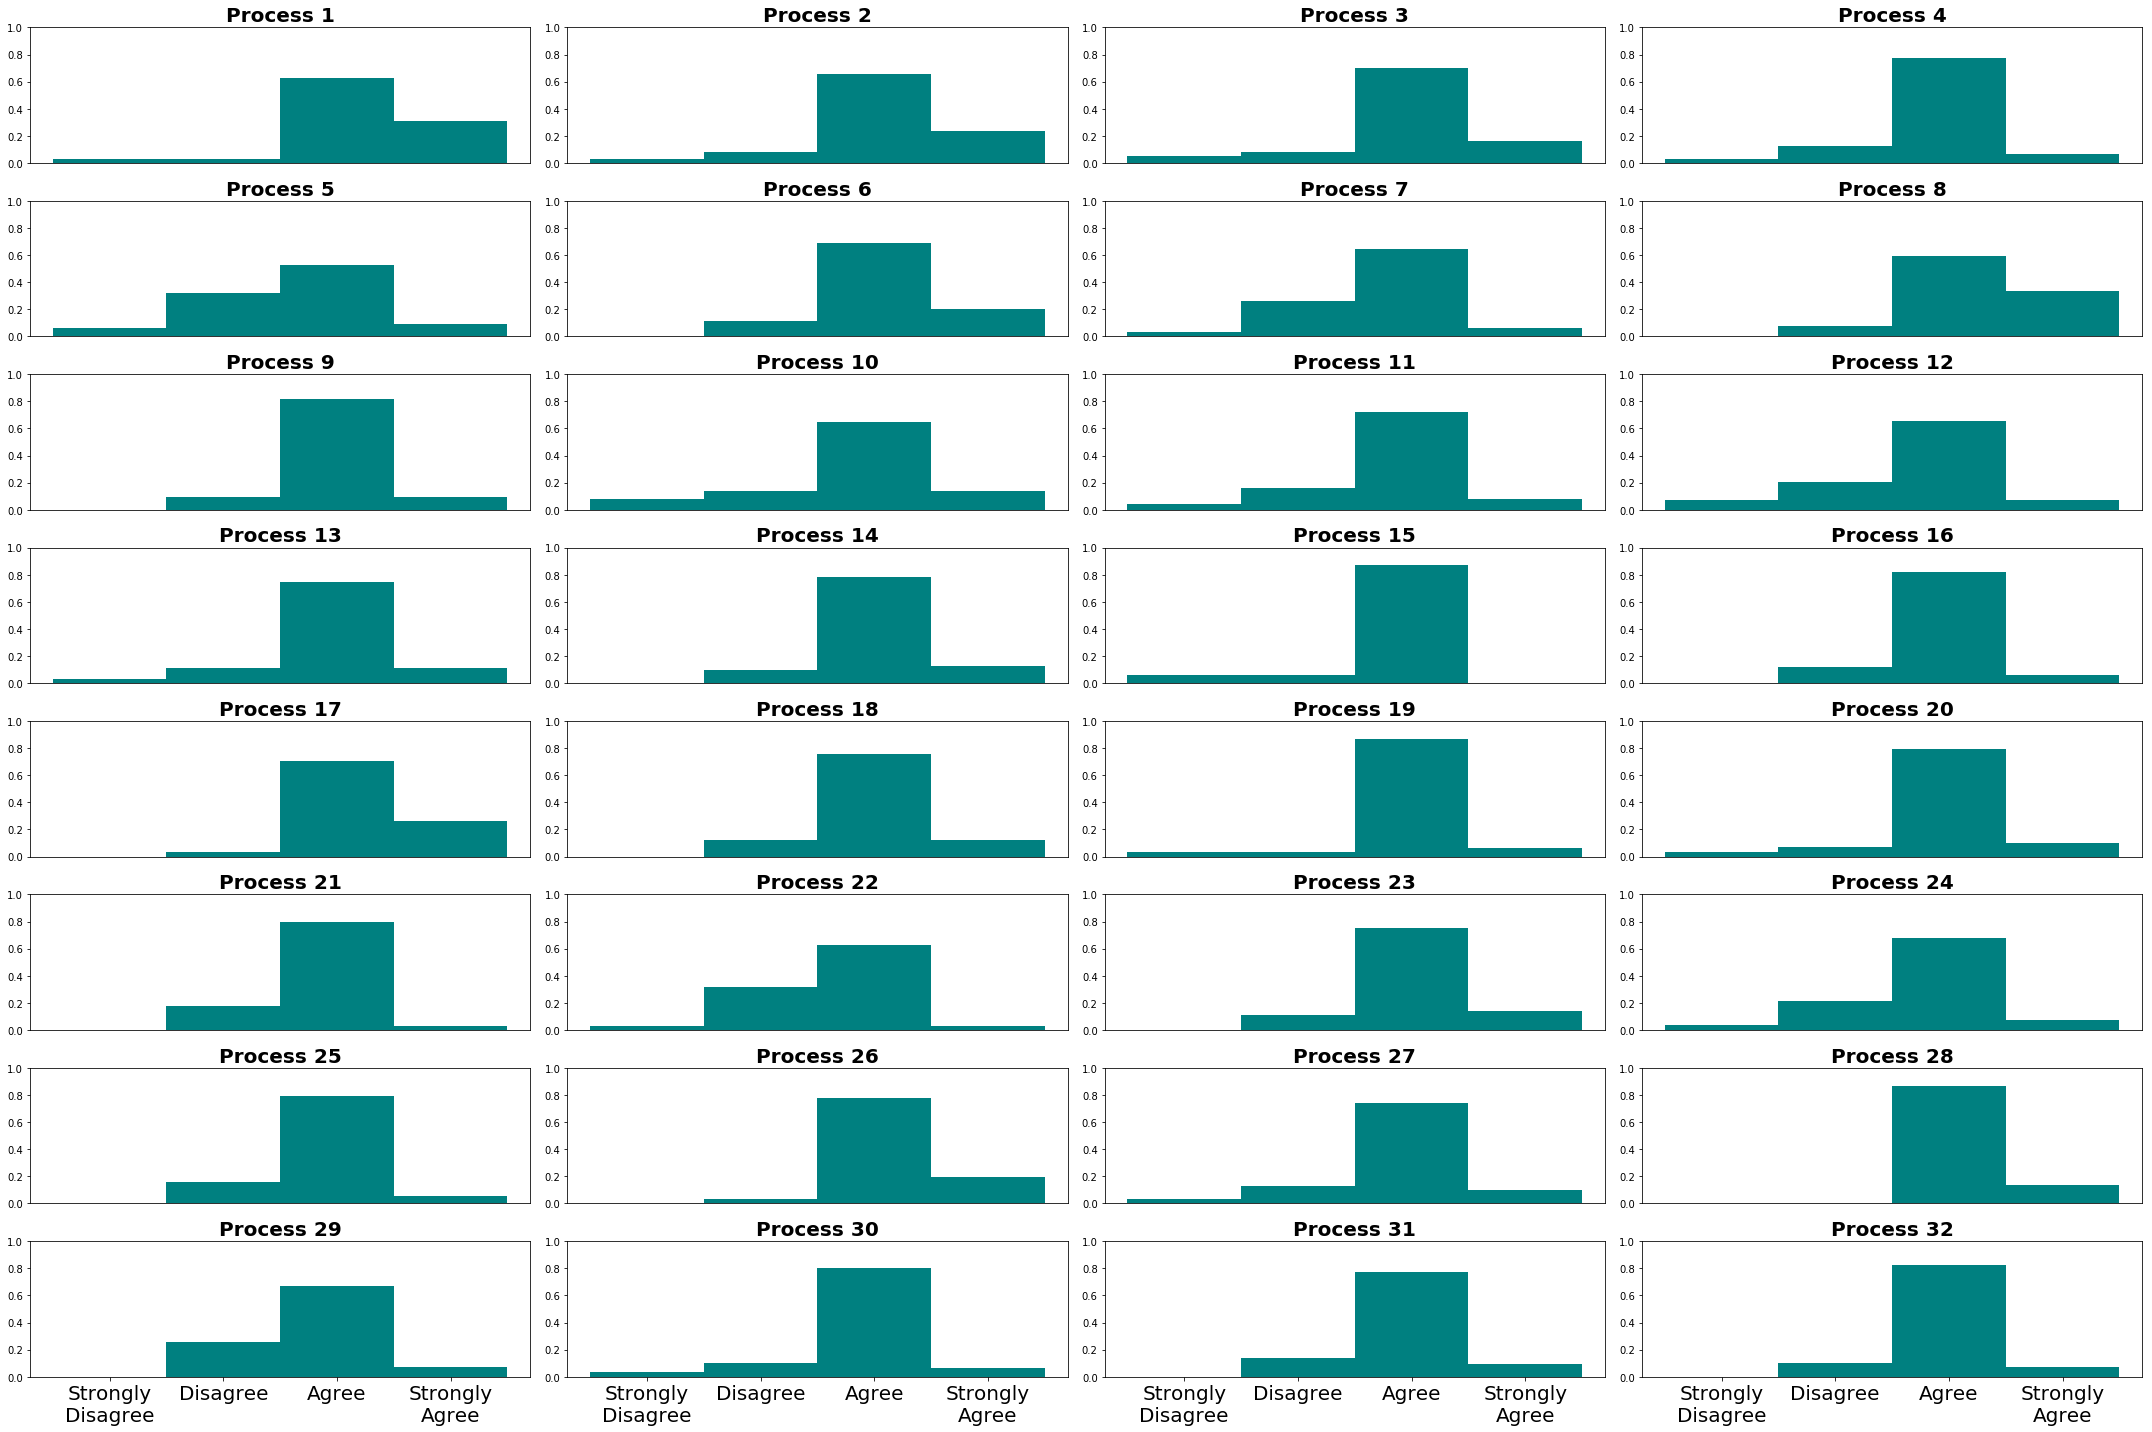

In [36]:
fig = plt.figure(figsize=(30,20))

x = 1

for col in effective_q.columns:
    ax = fig.add_subplot(8,4,x)
    ax.set_ylim(0,1)
    d = effective_q[col].dropna()
    if x < 29:
        ax.axes.get_xaxis().set_visible(False)
    ax = plt.hist(d,[1,2,3,4,5],normed=True,color="teal")
    plt.title(col,fontsize='20',fontweight='bold')
    plt.tick_params(axis='x',labelsize='20')
    plt.xticks([1.5,2.5,3.5,4.5],['Strongly\nDisagree','Disagree','Agree','Strongly\nAgree'])
    x += 1
plt.tight_layout()

### Heat Map of Effective Responses (In Percentages)

In [37]:
generate_heat_map(effective_q,{0:'Do Not Use',1:'Strongly Disagree',2:'Disagree',3:'Agree',4:'Strongly Agree'},'Teal')

## Effective to Often Used Ratio

In [38]:
ratio = pd.DataFrame({'Process' : columns,
                      'Ratio' : unsort_often_mean[0] / unsort_eff_mean[0] 
                     })
ratio.sort_values(by='Ratio',ascending=False)

Process     Ratio
1    Process 2  1.135169
4    Process 5  1.076667
7    Process 8  1.059449
2    Process 3  1.025909
17  Process 18  0.925000
22  Process 23  0.891743
9   Process 10  0.810476
20  Process 21  0.771134
12  Process 13  0.755660
5    Process 6  0.672454
3    Process 4  0.670506
27  Process 28  0.646277
31  Process 32  0.640698
26  Process 27  0.637222
16  Process 17  0.636207
28  Process 29  0.630592
11  Process 12  0.624051
0    Process 1  0.621359
29  Process 30  0.586207
6    Process 7  0.547059
23  Process 24  0.538462
25  Process 26  0.537755
13  Process 14  0.536082
19  Process 20  0.514244
18  Process 19  0.463483
10  Process 11  0.431338
30  Process 31  0.423077
15  Process 16  0.399500
21  Process 22  0.366935
8    Process 9  0.366667
24  Process 25  0.336818
14  Process 15  0.302222

## Correlation Table of Each Process

In [39]:
cmap = sns.diverging_palette(5, 250, as_cmap=True)

corr = survey.corr()

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())




C:\Users\anorum\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)
